In [1]:
import sys
import numpy as np
from numpy import pi
from scipy.special import jv, hankel2
from scipy.sparse import dia_matrix
from matplotlib import pyplot as plt
sys.path.insert(1, '../../../eispy2d/library/')

# Import module
import configuration as cfg
import experiment as exp
import inputdata as ipt
import analytical as ana
import mom_cg_fft as mom
import imsa_pso

In [2]:
# Transform cartesian coordinates into polar ones
def cart2polar(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    phi[phi<0] = 2*pi + phi[phi<0]
    return rho, phi

# Qual impacto de aumentar-se o número de equações?

Seja a função objetivo do problema dada por:

$$ min f_0(\chi, E_{z}) = \frac{\sum_{m=1}^M |E_{z,m}^s + \sum_{n=1}^N h_{mn}\chi_nE_{z,n}|^2}{\sum_{m=1}^M |E_{z,m}^s|^2} + \frac{\sum_{n=1}^N |E_{z,n}^i - E_{z,n} - \sum_{m=1}^M h_{nm}\chi_mE_{z,m}|^2}{\sum_{n=1}^N |E_{z,n}^i|^2} $$

Se eu aumentar o número de equações através do aumento do número de medições e de incidências, o que vai acontecer com a solução? Ela terá menos ruído no final?

Neste estudo iremos rodar o algoritmo do PSO para o problema analítico do cilindro circular. Anteriormente, fazíamos experimentos com 10 medições e 10 incidências. Desta vez iremos triplicar o valor: 30 medições e 30 incidências. Vale à pena observar que esse número é bem mais alto do que o número de graus de liberdade para o problema (que é aproximadamente 5$\times$5).

In [3]:
# General parameters
lambdab = 1.
saved_files_path = './data/'

# Set up configurations
config = cfg.Configuration(name='2x2',
                           wavelength=lambdab,
                           background_permittivity=1.0,
                           image_size=[2., 2.],
                           perfect_dielectric=True,
                           number_sources=30,
                           number_measurements=30)
config.save(file_path=saved_files_path)

Nesse estudo, nós iremos empregar o PSO sem a estratégia de colocar a solução exata em um dos indivíduos originais, tendo em vista que isso por si já reduz bastante a ocorrência de ruídos na imagem. A inicialização das soluções portanto é aquela original: contraste são inicializados com números aleatórios por píxel seguindo uma distribuição uniforme e o campo é inicializado com uma aproximação de Born.

In [4]:
# Configuration of resolution reconstruction process
resolution = (7, 7)
number_iterations = 20000
number_particles = 250
MIWI = 20000  # Maximum number of iterations without improvement

# Set up methods
methods = imsa_pso.IMSA_PSO(config,
                            resolution,
                            alias='pso',
                            number_particles=250,
                            number_iterations=number_iterations,
                            max_iterations_without_improvement=MIWI)

# Build input object
scenario = ipt.InputData(name='dielectric_cylinder',
                         configuration_filename=config.name,
                         resolution=resolution,
                         noise=0.,
                         compute_map_error=True,
                         compute_residual_error=True,
                         compute_totalfield_error=True)

# Solve forward problem analytically
analytical_solution = ana.Analytical(config, number_terms=100)
analytical_solution.solve(scenario, contrast=1.,
                          SAVE_MAP=True,
                          radius_proportion=0.4)

A solução exata tem a seguinte avaliação:

Exact solution evaluation: 4.214e-01


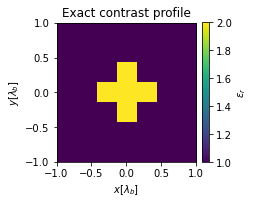

In [5]:
# Computing the incident field
M = config.NM
N = resolution[0]*resolution[1]
x, y = cfg.get_coordinates_ddomain(configuration=config, resolution=resolution)
rho, phi = cart2polar(x, y)
Eiz = analytical_solution.incident_field(resolution)
cell_area = np.sqrt((x[0, 1]-x[0, 0])*(y[1, 0]-y[0, 0])/pi)
xm, ym = cfg.get_coordinates_sdomain(config.Ro, config.NM)
kb = config.kb

# Data equation
HD = np.zeros((M, N), dtype=complex)
for m in range(M):
    R = np.sqrt((x-xm[m])**2 + (y-ym[m])**2).flatten()
    HD[m, :] = 1j*pi*kb*cell_area/2*jv(1, kb*cell_area)*hankel2(0, kb*R)

# State Equation
HS = np.zeros((N, N), dtype=complex)
for k in range(N):
    i, j = np.unravel_index(k, resolution)
    R = np.sqrt((x-x[i, j])**2 + (y-y[i, j])**2).flatten()
    HS[k, :] = 1j*pi*kb*cell_area/2*jv(1, kb*cell_area)*hankel2(0, kb*R)
    HS[k, R==0] = 1j/2*(pi*kb*cell_area*hankel2(1, kb*cell_area)-2j)

chi = scenario.epsilon_r/config.epsilon_rb - 1
fxexct = imsa_pso.Phi_eval([dia_matrix((chi.flatten(), 0), shape=(N, N))],
                           [scenario.et],
                           [HD],
                           [HS],
                           scenario.es,
                           [Eiz])

fig, axis = plt.subplots(ncols=2, sharey=True)

img = axis[0].imshow(scenario.epsilon_r, extent=[-config.Lx/2/config.lambda_b, config.Lx/2/config.lambda_b, -config.Ly/2/config.lambda_b, config.Ly/2/config.lambda_b])
clb = fig.colorbar(img, ax=axis[0], fraction=0.046, pad=0.04)
clb.set_label(r'$\epsilon_r$')
axis[0].set_xlabel(r'$x [\lambda_b]$')
axis[0].set_ylabel(r'$y [\lambda_b]$')
axis[0].set_title('Exact contrast profile')

axis[1].set_visible(False)

print('Exact solution evaluation: %.3e' % fxexct)

É interessante observar que a avaliação é a mesma de quando o problema tinha 10 medições por 10 incidências. Embora a quantidade de equações tanto de dados quanto de estados tenha subido, o valor da soma ponderada não mudou. Isso provavelmente está relacionado com a ponderação que leva em conta esse tipo de informação. Ou seja, esse tipo de ponderação equilibra a avaliação de modo soluções de problemas com dimensões maiores sejam comparáveis do ponto de vista de avaliação da função objetivo.

A execução do algoritmo segue abaixo:

In [6]:
result = methods.solve(scenario, max_contrast=1.0, print_info=True, number_executions=1, run_parallelly=False)

Method: IMSA-PSO
Alias: pso
Problem configuration: 2x2
Instance: dielectric_cylinder
Number of particles (P): 250
c1 = 2.0, c2 = 2.0, w = 0.4
Scaling steps (S): 1
Resolution steps: (7, 7)
Number of iterations: 20000
Number of executions: 1
Minimum contrast allowed: 0.000e+00
Maximum contrast allowed: 1.000e+00
Storing the best recovered image
Percent step for convergence sampling: 10.0
----------------------------------------
Scaling iteration 0 - Resolution:  (7, 7) , Area 4.000000
  PSO Iteration 0 - Best Phi(x): 1.612e+01
  PSO Iteration 2000 - Best Phi(x): 4.921e+00
  PSO Iteration 4000 - Best Phi(x): 2.151e+00
  PSO Iteration 6000 - Best Phi(x): 1.593e+00
  PSO Iteration 8000 - Best Phi(x): 1.307e+00
  PSO Iteration 10000 - Best Phi(x): 1.078e+00
  PSO Iteration 12000 - Best Phi(x): 1.028e+00
  PSO Iteration 14000 - Best Phi(x): 9.413e-01
  PSO Iteration 16000 - Best Phi(x): 9.101e-01
  PSO Iteration 18000 - Best Phi(x): 8.604e-01
  PSO Iteration 19999 - Best Phi(x): 8.535e-01


Nota-se que a avaliação da solução final obtida foi muita mais próxima (isso em somente uma execução) do que quando o algoritmo era rodado com 10 medições e 10 incidências. Como o algoritmo ainda se encontrava em processo de convergência, é possível que com mais interações o algoritmo chegasse a algo mais próximo da solução analítica (embora o número de iterações já represente um custo alto).

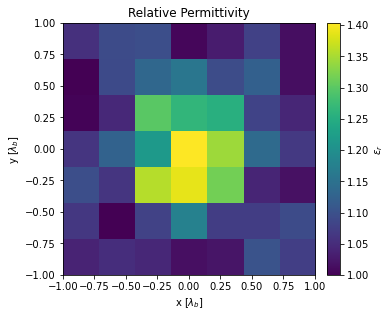

In [7]:
result.plot_map(show=True)

A imagem de contraste da solução final obtida já tem um aspecto que lembra um pouco a solução analítica. É possível ver que os píxels da borda receberam um valor menor de contraste e o píxels do centro receberam um valor maior. No entanto, nota-se o valor máximo de contraste recuperado é um pouco abaixo do valor da solução exata. De qualquer maneira, parece que o algoritmo caminhou para a região onde a solução analítica encontra, o que significaria também menos ruído na imagem reconstruída.

Seria interessante observar como isso se comporta com um número maior de píxels, onde ruídos são mais frequentes exatamente pelo problema ser bem maior.